# Import modules

In [1]:
from sklearn.datasets import load_diabetes
import pickle
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import os
import torch


from synthcity.metrics.eval_performance import (
    PerformanceEvaluatorMLP,
    PerformanceEvaluatorXGB,
)
from synthcity.utils import reproducibility
from synthcity.plugins import Plugins
import synthcity.logger as log
from synthcity.plugins.core.dataloader import GenericDataLoader
from DGE_utils import metric_different_datasets, mean_across_pandas, add_std, get_folder_names

reproducibility.clear_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


assert device.type == 'cuda'
Plugins(categories=["generic"]).list()


[2023-11-23T03:31:25.287140+0000][1530][CRITICAL] load failed: 
GReaT is not installed. Please install it with pip install GReaT.
Please be aware that GReaT is only available for python >= 3.9.

[2023-11-23T03:31:25.288837+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:31:25.290983+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:31:25.299446+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


['marginal_distributions',
 'dummy_sampler',
 'arf',
 'bayesian_network',
 'nflow',
 'uniform_sampler',
 'tvae',
 'ddpm',
 'ctgan',
 'rtvae']

# Load data and settings

In [2]:
from DGE_data import get_real_and_synthetic

print("cuda available? " + str(torch.cuda.is_available()))
print("torch device: " + str(device))
# let's restrict ourselves to classification datasets
# datasets = ['moons', 'circles', 'breast_cancer',
#            'adult',  'seer', 'covid']
datasets = ['moons', 'circles', 'breast_cancer',
            'adult', 'covid']
# ['moons', 'circles','cal_housing', 'adult', 'diabetes', 'breast_cancer',  'seer', 'cutract' ]
model_name = 'tvae'  # synthetic data model

n_models = 5  # number of models in ensemble, for each run orig: 20
max_n = 2000  # maximum number of data points to use for training generative model.
nsyn = 2000  # number of synthetic data points per synthetic dataset. Defaults to same as generative training size if None

num_runs = 5 # Number of runs. Don't choose to large, since total number of synthetic datasets is num_runs*n_models, orig:10

# Whether to load and save models and synthetic datasets
load = True  # results
load_syn = True  # data
save = True  # save results and data

verbose = True

cuda available? True
torch device: cuda


# Experiments

## Model Training

Loading real data...
   age          workclass  fnlwgt   education  education.num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital.status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital.gain  capital.loss  hours.per.week  native.country  income  
0          2174             0              40  

[2023-11-23T03:31:38.615890+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:31:38.617158+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:31:38.618396+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:31:38.620410+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


original income column: 
 0         <=50K
1         <=50K
2         <=50K
3         <=50K
4         <=50K
          ...  
48837    <=50K.
48838    <=50K.
48839    <=50K.
48840    <=50K.
48841     >50K.
Name: income, Length: 48842, dtype: object
after mapping: 
 0        0
1        0
2        0
3        0
4        0
        ..
48837    0
48838    0
48839    0
48840    0
48841    1
Name: income, Length: 48842, dtype: int64
input features: 
        age  workclass  fnlwgt  education.num  marital.status  occupation  \
0       39          7   77516             13               4           1   
1       50          6   83311             13               2           4   
2       38          4  215646              9               0           6   
3       53          4  234721              7               2           6   
4       28          4  338409             13               2          10   
...    ...        ...     ...            ...             ...         ...   
48837   39          4  21

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/tmp/tmps5untnx8
INFO:torch.distributed.nn.jit.instantiator:Writing /var/tmp/tmps5untnx8/_remote_module_non_scriptable.py
 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:23<02:23,  3.48it/s]
[2023-11-23T03:34:13.032896+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:34:13.034189+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:34:13.036753+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:34:13.038796+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed1.pkl
Training model 2/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:17<02:17,  3.63it/s]
[2023-11-23T03:36:38.831431+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:36:38.832665+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:36:38.833618+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:36:38.836092+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed2.pkl
Training model 3/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:19<02:19,  3.59it/s]
[2023-11-23T03:39:06.253495+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:39:06.254851+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:39:06.256493+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:39:06.259179+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed3.pkl
Training model 4/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:17<02:17,  3.63it/s]
[2023-11-23T03:41:31.814762+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:41:31.816708+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:41:31.818918+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:41:31.821116+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed4.pkl
Training model 5/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:16<02:16,  3.66it/s]
[2023-11-23T03:43:56.410809+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:43:56.414193+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:43:56.415121+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:43:56.417738+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed5.pkl
Training model 6/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:16<02:16,  3.66it/s]
[2023-11-23T03:46:21.203976+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:46:21.205162+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:46:21.207722+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:46:21.210944+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed6.pkl
Training model 7/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.73it/s]
[2023-11-23T03:48:42.883136+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:48:42.886550+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:48:42.887602+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:48:42.890083+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed7.pkl
Training model 8/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:15<02:15,  3.70it/s]
[2023-11-23T03:51:06.459203+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:51:06.460471+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:51:06.462761+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:51:06.464193+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed8.pkl
Training model 9/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.75it/s]
[2023-11-23T03:53:27.560558+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:53:27.561873+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:53:27.564473+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:53:27.566126+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed9.pkl
Training model 10/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.74it/s]
[2023-11-23T03:55:48.924804+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:55:48.926039+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:55:48.927729+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:55:48.930509+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed10.pkl
Training model 11/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:14<02:14,  3.71it/s]
[2023-11-23T03:58:11.567887+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:58:11.569081+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T03:58:11.571512+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T03:58:11.572905+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed11.pkl
Training model 12/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:17<02:17,  3.63it/s]
[2023-11-23T04:00:37.174264+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:00:37.175462+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:00:37.176267+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:00:37.178936+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed12.pkl
Training model 13/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.76it/s]
[2023-11-23T04:02:57.948433+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:02:57.949689+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:02:57.950526+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:02:57.953231+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed13.pkl
Training model 14/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:14<02:14,  3.73it/s]
[2023-11-23T04:05:20.337217+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:05:20.338551+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:05:20.341140+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:05:20.342893+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed14.pkl
Training model 15/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.73it/s]
[2023-11-23T04:07:42.059199+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:07:42.060408+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:07:42.061196+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:07:42.063748+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed15.pkl
Training model 16/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:14<02:14,  3.71it/s]
[2023-11-23T04:10:04.948485+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:10:04.949782+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:10:04.950665+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:10:04.958351+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed16.pkl
Training model 17/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.75it/s]
[2023-11-23T04:12:26.059672+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:12:26.060939+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:12:26.063569+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:12:26.065365+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed17.pkl
Training model 18/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:12<02:12,  3.77it/s]
[2023-11-23T04:14:46.422875+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:14:46.424252+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:14:46.426926+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:14:46.428668+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed18.pkl
Training model 19/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:15<02:15,  3.69it/s]
[2023-11-23T04:17:09.862842+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:17:09.864678+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:17:09.866772+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:17:09.869138+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed19.pkl
Training model 20/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.74it/s]
[2023-11-23T04:19:31.263947+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:19:31.265068+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:19:31.267423+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:19:31.268891+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed20.pkl
Training model 21/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.75it/s]
[2023-11-23T04:21:52.209047+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:21:52.210215+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:21:52.211323+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:21:52.213905+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed21.pkl
Training model 22/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:15<02:15,  3.68it/s]
[2023-11-23T04:24:15.786790+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:24:15.788001+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:24:15.789010+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:24:15.793201+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed22.pkl
Training model 23/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.74it/s]
[2023-11-23T04:26:37.016669+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:26:37.017900+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:26:37.020364+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:26:37.022486+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed23.pkl
Training model 24/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:12<02:12,  3.76it/s]
[2023-11-23T04:28:57.598220+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:28:57.599451+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T04:28:57.601995+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T04:28:57.603854+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/tvae/Xsyn_n2000_seed24.pkl
Training model 25/25


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 500/1000 [02:13<02:13,  3.74it/s]


Finished with synthetic data generation!
Dataset adult

targettype:  classification
\begin{tabular}{lrrrrrrr}
\toprule
{} &       AUC &       Acc &        F1 &  Precision &    Recall &       NLL &     Brier \\
\midrule
Oracle              &  0.857023 &  0.809914 &  0.592830 &   0.608068 &  0.578337 &  0.506772 &  0.139093 \\
Naive (S)           &  0.745755 &  0.787029 &  0.433954 &   0.596010 &  0.341185 &  0.905341 &  0.175967 \\
Naive (E)           &  0.784025 &  0.794052 &  0.462113 &   0.616025 &  0.369736 &  0.547085 &  0.154151 \\
DGE\$\_\{5\}\$           &  0.776065 &  0.790637 &  0.464537 &   0.598565 &  0.379550 &  0.607757 &  0.157876 \\
DGE\$\_\{10\}\$          &  0.781384 &  0.792964 &  0.466322 &   0.608415 &  0.378034 &  0.572122 &  0.155128 \\
DGE\$\_\{20\}\$          &  0.784030 &  0.792750 &  0.464711 &   0.608256 &  0.375981 &  0.550062 &  0.154297 \\
DGE\$\_\{20\}\$ (concat) &  0.736815 &  0.752829 &  0.452214 &   0.481366 &  0.426392 &  3.247981 &  0.232554 \\
\bott

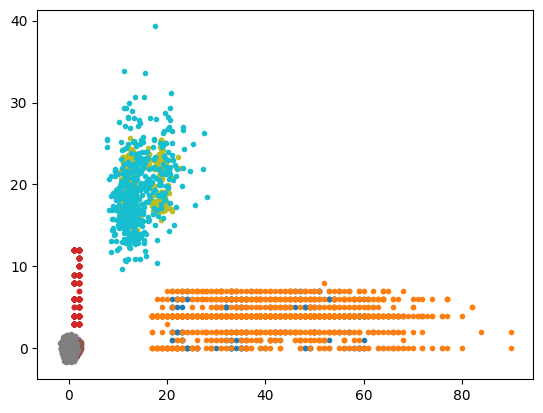

In [3]:
from DGE_experiments import predictive_experiment
import pandas as pd


all_means = {}
all_stds = {}

#datasets = ['moons', 'circles', 'breast_cancer', 'adult', 'covid', 'seer']
datasets = ['adult', 'covid', 'moons', 'circles', 'breast_cancer']
#num_runs=10
model_type = 'deepish_mlp'

for dataset in datasets:
    workspace_folder, results_folder = get_folder_names(
        dataset, model_name, max_n=max_n, nsyn=nsyn)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                          n_models=n_models*num_runs,
                                          model_name=model_name,
                                          load_syn=load_syn,
                                          verbose=verbose,
                                          max_n=max_n,
                                          nsyn=nsyn)


    print(f'Dataset {dataset}\n')

    means, stds, _ = predictive_experiment(X_gt,
                                            X_syns,
                                            workspace_folder=workspace_folder,
                                            results_folder=results_folder,
                                            save=save,
                                            load=load,
                                            plot=False,
                                            task_type = model_type
                                            )

    print(means.to_latex())

    all_means[dataset] = means
    all_stds[dataset] = stds



In [4]:
# Print results, aggregated over different datasets
means_consolidated = metric_different_datasets(all_means, to_print=False)
if num_runs>1:
    stds_consolidated = metric_different_datasets(all_stds, to_print=False)
    stds_consolidated.drop(columns=['Mean'], inplace=True)
    print(add_std(means_consolidated, stds_consolidated).to_latex())
else:
    print(means_consolidated.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &        Moons &      Circles & Adult Income & Breast Cancer &     COVID-19 &   Mean \\
\midrule
Oracle              &  0.996 ± 0.0 &  0.868 ± 0.0 &  0.857 ± 0.0 &   0.993 ± 0.0 &  0.929 ± 0.0 &  0.929 \\
Naive (S)           &  0.989 ± 0.0 &   0.86 ± 0.0 &  0.746 ± 0.0 &   0.959 ± 0.0 &  0.787 ± 0.0 &  0.868 \\
Naive (E)           &  0.988 ± 0.0 &  0.861 ± 0.0 &  0.784 ± 0.0 &   0.968 ± 0.0 &  0.837 ± 0.0 &  0.887 \\
DGE\$\_\{5\}\$           &  0.987 ± 0.0 &  0.861 ± 0.0 &  0.776 ± 0.0 &    0.97 ± 0.0 &  0.818 ± 0.0 &  0.882 \\
DGE\$\_\{10\}\$          &  0.987 ± 0.0 &  0.861 ± 0.0 &  0.781 ± 0.0 &   0.965 ± 0.0 &  0.833 ± 0.0 &  0.886 \\
DGE\$\_\{20\}\$          &  0.987 ± 0.0 &  0.861 ± 0.0 &  0.784 ± 0.0 &   0.963 ± 0.0 &  0.835 ± 0.0 &  0.886 \\
DGE\$\_\{20\}\$ (concat) &   0.92 ± 0.0 &  0.691 ± 0.0 &  0.737 ± 0.0 &   0.932 ± 0.0 &  0.763 ± 0.0 &  0.809 \\
\bottomrule
\end{tabular}



### Run over generative model sizes
Let us study what happens when we run the generative model for different sizes.

Loading real data...
   age          workclass  fnlwgt   education  education.num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital.status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital.gain  capital.loss  hours.per.week  native.country  income  
0          2174             0              40  

[2023-11-23T05:18:34.923413+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:18:34.924771+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:18:34.926956+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T05:18:34.928460+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


input features: 
        age  workclass  fnlwgt  education.num  marital.status  occupation  \
0       39          7   77516             13               4           1   
1       50          6   83311             13               2           4   
2       38          4  215646              9               0           6   
3       53          4  234721              7               2           6   
4       28          4  338409             13               2          10   
...    ...        ...     ...            ...             ...         ...   
48837   39          4  215419             13               0          10   
48838   64          0  321403              9               6           0   
48839   38          4  374983             13               2          10   
48840   44          4   83891             13               0           1   
48841   35          5  182148             13               2           4   

       relationship  race  sex  capital.gain  capital.loss  hours.per

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1199/2000 [16:07<10:46,  1.24it/s]
[2023-11-23T05:34:55.588728+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:34:55.589988+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:34:55.591512+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T05:34:55.593605+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed1.pkl
Training model 2/50


 20%|█████████████████████████████████                                                                                                                                     | 399/2000 [05:12<20:55,  1.28it/s]
[2023-11-23T05:40:22.331707+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:40:22.332907+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:40:22.335366+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T05:40:22.337140+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed2.pkl
Training model 3/50


 32%|█████████████████████████████████████████████████████▊                                                                                                                | 649/2000 [08:22<17:25,  1.29it/s]
[2023-11-23T05:48:57.870658+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:48:57.871880+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:48:57.874341+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T05:48:57.876273+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed3.pkl
Training model 4/50


 25%|█████████████████████████████████████████▍                                                                                                                            | 499/2000 [06:18<18:59,  1.32it/s]
[2023-11-23T05:55:30.671781+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:55:30.672872+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T05:55:30.673939+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T05:55:30.677187+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed4.pkl
Training model 5/50


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1449/2000 [18:49<07:09,  1.28it/s]
[2023-11-23T06:14:33.178383+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:14:33.179632+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:14:33.182152+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T06:14:33.183983+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed5.pkl
Training model 6/50


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 999/2000 [12:45<12:47,  1.30it/s]
[2023-11-23T06:27:32.168922+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:27:32.170172+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:27:32.172830+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T06:27:32.174727+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed6.pkl
Training model 7/50


 35%|██████████████████████████████████████████████████████████                                                                                                            | 699/2000 [08:36<16:00,  1.35it/s]
[2023-11-23T06:36:21.683236+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:36:21.684292+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:36:21.686924+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T06:36:21.688793+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed7.pkl
Training model 8/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [07:11<16:49,  1.39it/s]
[2023-11-23T06:43:46.690751+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:43:46.692013+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:43:46.694460+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T06:43:46.696200+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed8.pkl
Training model 9/50


 35%|██████████████████████████████████████████████████████████                                                                                                            | 699/2000 [08:24<15:38,  1.39it/s]
[2023-11-23T06:52:24.383206+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:52:24.384367+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T06:52:24.386991+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T06:52:24.388710+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed9.pkl
Training model 10/50


 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                           | 899/2000 [10:54<13:21,  1.37it/s]
[2023-11-23T07:03:31.778679+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:03:31.779834+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:03:31.782196+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T07:03:31.784667+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed10.pkl
Training model 11/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [08:49<14:44,  1.42it/s]
[2023-11-23T07:12:34.241358+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:12:34.242469+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:12:34.244936+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T07:12:34.246670+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed11.pkl
Training model 12/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [08:42<14:32,  1.43it/s]
[2023-11-23T07:21:30.082214+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:21:30.083311+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:21:30.085802+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T07:21:30.088812+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed12.pkl
Training model 13/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [08:37<14:24,  1.45it/s]
[2023-11-23T07:30:21.590708+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:30:21.591755+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:30:21.593956+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T07:30:21.596051+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed13.pkl
Training model 14/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [08:30<14:12,  1.47it/s]
[2023-11-23T07:39:05.320256+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:39:05.324382+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:39:05.328198+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T07:39:05.332153+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed14.pkl
Training model 15/50


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 999/2000 [11:36<11:37,  1.44it/s]
[2023-11-23T07:50:54.996860+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:50:54.997942+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T07:50:55.000442+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T07:50:55.002117+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed15.pkl
Training model 16/50


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 999/2000 [11:34<11:35,  1.44it/s]
[2023-11-23T08:02:42.823800+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:02:42.824959+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:02:42.826559+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T08:02:42.829909+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed16.pkl
Training model 17/50


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 999/2000 [11:34<11:35,  1.44it/s]
[2023-11-23T08:14:30.325768+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:14:30.327027+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:14:30.329429+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T08:14:30.331664+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed17.pkl
Training model 18/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [13:23<09:54,  1.43it/s]
[2023-11-23T08:28:06.874483+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:28:06.875698+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:28:06.878342+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T08:28:06.880203+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed18.pkl
Training model 19/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [13:13<09:47,  1.45it/s]
[2023-11-23T08:41:34.147529+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:41:34.148649+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:41:34.150962+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T08:41:34.152856+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed19.pkl
Training model 20/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [13:07<09:43,  1.46it/s]
[2023-11-23T08:54:54.755985+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:54:54.757228+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T08:54:54.759743+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T08:54:54.761593+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed20.pkl
Training model 21/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [13:00<09:37,  1.47it/s]
[2023-11-23T09:08:08.521673+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T09:08:08.522824+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T09:08:08.525130+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T09:08:08.526976+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed21.pkl
Training model 22/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:53<09:33,  1.48it/s]
[2023-11-23T09:21:15.685025+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T09:21:15.686220+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T09:21:15.688635+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T09:21:15.690499+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed22.pkl
Training model 23/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:45<09:27,  1.50it/s]
[2023-11-23T09:34:14.820855+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T09:34:14.821869+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T09:34:14.824288+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T09:34:14.827363+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed23.pkl
Training model 24/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:40<09:23,  1.51it/s]
[2023-11-23T09:47:08.668843+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T09:47:08.670007+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T09:47:08.672224+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T09:47:08.673922+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed24.pkl
Training model 25/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:38<09:21,  1.51it/s]
[2023-11-23T10:00:00.401816+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T10:00:00.402970+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T10:00:00.405202+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T10:00:00.407119+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed25.pkl
Training model 26/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:38<09:22,  1.51it/s]
[2023-11-23T10:12:52.666370+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T10:12:52.667560+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T10:12:52.669979+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T10:12:52.671833+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed26.pkl
Training model 27/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:36<09:20,  1.52it/s]
[2023-11-23T10:25:42.340601+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T10:25:42.341760+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T10:25:42.344077+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T10:25:42.345959+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed27.pkl
Training model 28/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:39<09:22,  1.51it/s]
[2023-11-23T10:38:34.612633+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T10:38:34.613842+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T10:38:34.616215+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T10:38:34.618036+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed28.pkl
Training model 29/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:38<09:21,  1.51it/s]
[2023-11-23T10:51:26.583605+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T10:51:26.584816+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T10:51:26.587164+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T10:51:26.589056+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed29.pkl
Training model 30/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:40<09:23,  1.51it/s]
[2023-11-23T11:04:20.510884+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T11:04:20.512167+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T11:04:20.514547+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T11:04:20.516375+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed30.pkl
Training model 31/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:40<09:23,  1.51it/s]
[2023-11-23T11:17:13.938877+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T11:17:13.940082+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T11:17:13.942514+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T11:17:13.944391+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed31.pkl
Training model 32/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:39<09:22,  1.51it/s]
[2023-11-23T11:30:06.965960+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T11:30:06.967153+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T11:30:06.969543+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T11:30:06.971433+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed32.pkl
Training model 33/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:37<09:21,  1.52it/s]
[2023-11-23T11:42:58.040740+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T11:42:58.041942+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T11:42:58.044453+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T11:42:58.046260+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed33.pkl
Training model 34/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:35<09:19,  1.52it/s]
[2023-11-23T11:55:46.803108+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T11:55:46.804284+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T11:55:46.806778+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T11:55:46.808591+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed34.pkl
Training model 35/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:38<09:21,  1.51it/s]
[2023-11-23T12:08:38.399443+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T12:08:38.400650+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T12:08:38.403010+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T12:08:38.404753+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed35.pkl
Training model 36/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:38<09:21,  1.52it/s]
[2023-11-23T12:21:29.871598+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T12:21:29.872789+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T12:21:29.875226+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T12:21:29.877057+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed36.pkl
Training model 37/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:40<09:23,  1.51it/s]
[2023-11-23T12:34:23.890954+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T12:34:23.892160+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T12:34:23.894697+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T12:34:23.896619+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed37.pkl
Training model 38/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:38<09:21,  1.52it/s]
[2023-11-23T12:47:15.474399+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T12:47:15.475624+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T12:47:15.478120+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T12:47:15.480128+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed38.pkl
Training model 39/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:38<09:22,  1.51it/s]
[2023-11-23T13:00:07.720730+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T13:00:07.722044+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T13:00:07.724604+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T13:00:07.726656+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed39.pkl
Training model 40/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:35<09:19,  1.52it/s]
[2023-11-23T13:12:56.952715+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T13:12:56.953865+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T13:12:56.956247+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T13:12:56.958159+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed40.pkl
Training model 41/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:34<09:18,  1.52it/s]
[2023-11-23T13:25:44.935824+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T13:25:44.936919+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T13:25:44.939393+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T13:25:44.940987+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed41.pkl
Training model 42/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:38<09:21,  1.51it/s]
[2023-11-23T13:38:36.901569+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T13:38:36.902892+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T13:38:36.905287+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T13:38:36.907013+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed42.pkl
Training model 43/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:42<09:24,  1.51it/s]
[2023-11-23T13:51:32.469758+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T13:51:32.470825+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T13:51:32.473370+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T13:51:32.475164+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed43.pkl
Training model 44/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:38<09:21,  1.52it/s]
[2023-11-23T14:04:23.565979+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T14:04:23.567157+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T14:04:23.569847+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T14:04:23.571658+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed44.pkl
Training model 45/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:41<09:23,  1.51it/s]
[2023-11-23T14:17:18.341241+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T14:17:18.342479+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T14:17:18.344973+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T14:17:18.346906+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed45.pkl
Training model 46/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:40<09:23,  1.51it/s]
[2023-11-23T14:30:12.598930+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T14:30:12.600081+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T14:30:12.602527+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T14:30:12.604425+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed46.pkl
Training model 47/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:35<09:19,  1.52it/s]
[2023-11-23T14:43:00.846137+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T14:43:00.847279+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T14:43:00.849805+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T14:43:00.852465+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed47.pkl
Training model 48/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:37<09:21,  1.52it/s]
[2023-11-23T14:55:51.852703+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T14:55:51.853901+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T14:55:51.856387+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T14:55:51.858206+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed48.pkl
Training model 49/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:39<09:22,  1.51it/s]
[2023-11-23T15:08:44.382781+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T15:08:44.383917+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T15:08:44.386230+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T15:08:44.387779+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_shallow/Xsyn_n5000_seed49.pkl
Training model 50/50


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1149/2000 [12:42<09:24,  1.51it/s]


Finished with synthetic data generation!
Model ctgan_shallow

targettype:  classification
Loading real data...
   age          workclass  fnlwgt   education  education.num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital.status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital.gain  capital.loss

[2023-11-23T16:19:22.335472+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T16:19:22.336698+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T16:19:22.338988+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T16:19:22.340278+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


input features: 
        age  workclass  fnlwgt  education.num  marital.status  occupation  \
0       39          7   77516             13               4           1   
1       50          6   83311             13               2           4   
2       38          4  215646              9               0           6   
3       53          4  234721              7               2           6   
4       28          4  338409             13               2          10   
...    ...        ...     ...            ...             ...         ...   
48837   39          4  215419             13               0          10   
48838   64          0  321403              9               6           0   
48839   38          4  374983             13               2          10   
48840   44          4   83891             13               0           1   
48841   35          5  182148             13               2           4   

       relationship  race  sex  capital.gain  capital.loss  hours.per

 32%|█████████████████████████████████████████████████████▊                                                                                                                | 649/2000 [09:17<19:21,  1.16it/s]
[2023-11-23T16:28:53.309771+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T16:28:53.311588+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T16:28:53.313151+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T16:28:53.314845+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed1.pkl
Training model 2/50


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                               | 849/2000 [12:12<16:32,  1.16it/s]
[2023-11-23T16:41:18.869050+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T16:41:18.870222+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T16:41:18.872862+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T16:41:18.874582+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed2.pkl
Training model 3/50


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                               | 849/2000 [12:04<16:21,  1.17it/s]
[2023-11-23T16:53:36.320786+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T16:53:36.321955+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T16:53:36.324384+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T16:53:36.326187+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed3.pkl
Training model 4/50


 27%|█████████████████████████████████████████████▌                                                                                                                        | 549/2000 [07:41<20:20,  1.19it/s]
[2023-11-23T17:01:31.095442+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T17:01:31.096721+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T17:01:31.099203+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T17:01:31.100971+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed4.pkl
Training model 5/50


 35%|██████████████████████████████████████████████████████████                                                                                                            | 699/2000 [09:42<18:03,  1.20it/s]
[2023-11-23T17:11:26.450694+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T17:11:26.451822+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T17:11:26.454270+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T17:11:26.456558+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed5.pkl
Training model 6/50


 35%|██████████████████████████████████████████████████████████                                                                                                            | 699/2000 [09:34<17:49,  1.22it/s]
[2023-11-23T17:21:14.460579+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T17:21:14.461775+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T17:21:14.464032+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T17:21:14.466272+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed6.pkl
Training model 7/50


 32%|█████████████████████████████████████████████████████▊                                                                                                                | 649/2000 [08:43<18:09,  1.24it/s]
[2023-11-23T17:30:10.970266+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T17:30:10.971387+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T17:30:10.973917+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T17:30:10.975982+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed7.pkl
Training model 8/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [10:09<16:57,  1.23it/s]
[2023-11-23T17:40:33.510345+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T17:40:33.511469+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T17:40:33.513617+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T17:40:33.515119+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed8.pkl
Training model 9/50


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 999/2000 [13:35<13:37,  1.22it/s]
[2023-11-23T17:54:22.650809+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T17:54:22.652119+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T17:54:22.654563+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T17:54:22.656295+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed9.pkl
Training model 10/50


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 999/2000 [13:32<13:33,  1.23it/s]
[2023-11-23T18:08:08.008341+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T18:08:08.009563+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T18:08:08.012005+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T18:08:08.013876+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed10.pkl
Training model 11/50


 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                           | 899/2000 [11:59<14:41,  1.25it/s]
[2023-11-23T18:20:20.949781+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T18:20:20.950835+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T18:20:20.952728+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T18:20:20.956024+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed11.pkl
Training model 12/50


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 999/2000 [13:14<13:15,  1.26it/s]
[2023-11-23T18:33:48.673965+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T18:33:48.675183+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T18:33:48.677828+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T18:33:48.679680+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed12.pkl
Training model 13/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:30<15:52,  1.31it/s]
[2023-11-23T18:43:32.236489+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T18:43:32.237604+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T18:43:32.239695+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T18:43:32.243000+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed13.pkl
Training model 14/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:24<15:42,  1.33it/s]
[2023-11-23T18:53:09.823617+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T18:53:09.824699+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T18:53:09.827069+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T18:53:09.828940+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed14.pkl
Training model 15/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:14<15:26,  1.35it/s]
[2023-11-23T19:02:37.913619+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T19:02:37.914661+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T19:02:37.915758+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T19:02:37.919802+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed15.pkl
Training model 16/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:09<15:17,  1.36it/s]
[2023-11-23T19:12:00.428529+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T19:12:00.429783+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T19:12:00.432295+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T19:12:00.434677+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed16.pkl
Training model 17/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:08<15:16,  1.37it/s]
[2023-11-23T19:21:22.490229+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T19:21:22.491800+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T19:21:22.493841+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T19:21:22.496258+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed17.pkl
Training model 18/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:09<15:17,  1.36it/s]
[2023-11-23T19:30:44.753134+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T19:30:44.754363+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T19:30:44.756684+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T19:30:44.758659+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed18.pkl
Training model 19/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:12<15:23,  1.35it/s]
[2023-11-23T19:40:10.833583+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T19:40:10.834815+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T19:40:10.837288+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T19:40:10.839210+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed19.pkl
Training model 20/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:09<15:18,  1.36it/s]
[2023-11-23T19:49:33.771074+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T19:49:33.772366+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T19:49:33.775102+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T19:49:33.776879+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed20.pkl
Training model 21/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:09<15:17,  1.36it/s]
[2023-11-23T19:58:56.449631+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T19:58:56.450911+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T19:58:56.453367+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T19:58:56.455183+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed21.pkl
Training model 22/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:09<15:18,  1.36it/s]
[2023-11-23T20:08:19.647670+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T20:08:19.648845+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T20:08:19.651336+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T20:08:19.653196+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed22.pkl
Training model 23/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:10<15:18,  1.36it/s]
[2023-11-23T20:17:42.968895+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T20:17:42.970145+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T20:17:42.972609+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T20:17:42.974639+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed23.pkl
Training model 24/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:10<15:19,  1.36it/s]
[2023-11-23T20:27:06.982660+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T20:27:06.983882+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T20:27:06.986298+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T20:27:06.988277+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed24.pkl
Training model 25/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:14<15:26,  1.35it/s]
[2023-11-23T20:36:35.032725+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T20:36:35.033972+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T20:36:35.036161+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T20:36:35.037675+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed25.pkl
Training model 26/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:13<15:23,  1.35it/s]
[2023-11-23T20:46:01.450148+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T20:46:01.451267+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T20:46:01.452440+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T20:46:01.456091+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed26.pkl
Training model 27/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:09<15:17,  1.36it/s]
[2023-11-23T20:55:24.622305+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T20:55:24.623556+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T20:55:24.626045+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T20:55:24.627871+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed27.pkl
Training model 28/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:11<15:20,  1.36it/s]
[2023-11-23T21:04:49.033070+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T21:04:49.034404+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T21:04:49.037040+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T21:04:49.038948+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed28.pkl
Training model 29/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:12<15:22,  1.36it/s]
[2023-11-23T21:14:14.851083+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T21:14:14.852242+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T21:14:14.854959+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T21:14:14.856497+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed29.pkl
Training model 30/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:09<15:18,  1.36it/s]
[2023-11-23T21:23:38.170295+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T21:23:38.171612+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T21:23:38.174070+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T21:23:38.176033+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed30.pkl
Training model 31/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:08<15:16,  1.36it/s]
[2023-11-23T21:33:00.156223+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T21:33:00.158055+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T21:33:00.159122+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T21:33:00.161251+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed31.pkl
Training model 32/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:09<15:18,  1.36it/s]
[2023-11-23T21:42:23.552218+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T21:42:23.553443+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T21:42:23.555705+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T21:42:23.557315+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed32.pkl
Training model 33/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:10<15:19,  1.36it/s]
[2023-11-23T21:51:47.019932+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T21:51:47.021205+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T21:51:47.023615+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T21:51:47.025615+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed33.pkl
Training model 34/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:10<15:18,  1.36it/s]
[2023-11-23T22:01:10.296579+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T22:01:10.297631+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T22:01:10.299578+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T22:01:10.301821+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed34.pkl
Training model 35/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:10<15:20,  1.36it/s]
[2023-11-23T22:10:34.214305+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T22:10:34.215616+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T22:10:34.218073+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T22:10:34.219790+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed35.pkl
Training model 36/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:12<15:22,  1.36it/s]
[2023-11-23T22:19:59.955056+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T22:19:59.957005+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T22:19:59.958708+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T22:19:59.960328+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed36.pkl
Training model 37/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:09<15:17,  1.36it/s]
[2023-11-23T22:29:23.132909+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T22:29:23.134056+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T22:29:23.136648+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T22:29:23.138599+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed37.pkl
Training model 38/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:08<15:16,  1.37it/s]
[2023-11-23T22:38:44.864773+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T22:38:44.865837+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T22:38:44.868427+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T22:38:44.870170+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed38.pkl
Training model 39/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:11<15:20,  1.36it/s]
[2023-11-23T22:48:09.561643+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T22:48:09.562889+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T22:48:09.565210+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T22:48:09.567022+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed39.pkl
Training model 40/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:09<15:17,  1.36it/s]
[2023-11-23T22:57:32.269240+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T22:57:32.270418+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T22:57:32.272072+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T22:57:32.275404+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed40.pkl
Training model 41/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:11<15:20,  1.36it/s]
[2023-11-23T23:06:56.664790+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T23:06:56.666893+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T23:06:56.668492+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T23:06:56.670279+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed41.pkl
Training model 42/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:09<15:17,  1.36it/s]
[2023-11-23T23:16:19.526305+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T23:16:19.527616+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T23:16:19.530214+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T23:16:19.532157+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed42.pkl
Training model 43/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:07<15:15,  1.37it/s]
[2023-11-23T23:25:40.628528+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T23:25:40.629803+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T23:25:40.632472+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T23:25:40.634354+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed43.pkl
Training model 44/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:08<15:15,  1.37it/s]
[2023-11-23T23:35:01.846728+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T23:35:01.850346+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T23:35:01.853402+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T23:35:01.857576+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed44.pkl
Training model 45/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:10<15:19,  1.36it/s]
[2023-11-23T23:44:25.859697+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T23:44:25.860807+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T23:44:25.863311+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T23:44:25.865058+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed45.pkl
Training model 46/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:08<15:16,  1.36it/s]
[2023-11-23T23:53:47.906246+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T23:53:47.907403+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-23T23:53:47.910064+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-23T23:53:47.912698+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed46.pkl
Training model 47/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:10<15:19,  1.36it/s]
[2023-11-24T00:03:11.478164+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T00:03:11.479319+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T00:03:11.481359+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T00:03:11.483567+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed47.pkl
Training model 48/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:08<15:15,  1.37it/s]
[2023-11-24T00:12:32.537406+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T00:12:32.538582+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T00:12:32.540908+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T00:12:32.542760+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed48.pkl
Training model 49/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:09<15:17,  1.36it/s]
[2023-11-24T00:21:54.948305+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T00:21:54.949546+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T00:21:54.952071+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T00:21:54.953916+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan/Xsyn_n5000_seed49.pkl
Training model 50/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [09:08<15:15,  1.37it/s]


Finished with synthetic data generation!
Model ctgan

targettype:  classification
Loading real data...
   age          workclass  fnlwgt   education  education.num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital.status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital.gain  capital.loss  hours.

[2023-11-24T01:23:19.126934+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T01:23:19.128081+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T01:23:19.130385+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T01:23:19.131626+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


input features: 
        age  workclass  fnlwgt  education.num  marital.status  occupation  \
0       39          7   77516             13               4           1   
1       50          6   83311             13               2           4   
2       38          4  215646              9               0           6   
3       53          4  234721              7               2           6   
4       28          4  338409             13               2          10   
...    ...        ...     ...            ...             ...         ...   
48837   39          4  215419             13               0          10   
48838   64          0  321403              9               6           0   
48839   38          4  374983             13               2          10   
48840   44          4   83891             13               0           1   
48841   35          5  182148             13               2           4   

       relationship  race  sex  capital.gain  capital.loss  hours.per

 17%|████████████████████████████▉                                                                                                                                         | 349/2000 [05:36<26:32,  1.04it/s]
[2023-11-24T01:29:09.084169+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T01:29:09.085998+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T01:29:09.088224+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T01:29:09.089565+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed1.pkl
Training model 2/50


 40%|██████████████████████████████████████████████████████████████████▎                                                                                                   | 799/2000 [12:47<19:13,  1.04it/s]
[2023-11-24T01:42:09.740526+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T01:42:09.741605+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T01:42:09.744420+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T01:42:09.745826+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed2.pkl
Training model 3/50


 32%|█████████████████████████████████████████████████████▊                                                                                                                | 649/2000 [10:16<21:23,  1.05it/s]
[2023-11-24T01:52:39.652039+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T01:52:39.653111+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T01:52:39.655461+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T01:52:39.656911+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed3.pkl
Training model 4/50


 35%|██████████████████████████████████████████████████████████                                                                                                            | 699/2000 [10:51<20:13,  1.07it/s]
[2023-11-24T02:03:44.661285+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T02:03:44.663076+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T02:03:44.664385+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T02:03:44.665968+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed4.pkl
Training model 5/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [09:17<21:43,  1.07it/s]
[2023-11-24T02:13:15.414508+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T02:13:15.415619+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T02:13:15.417922+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T02:13:15.420251+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed5.pkl
Training model 6/50


 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                           | 899/2000 [13:54<17:02,  1.08it/s]
[2023-11-24T02:27:23.443693+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T02:27:23.444736+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T02:27:23.446832+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T02:27:23.448833+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed6.pkl
Training model 7/50


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                               | 849/2000 [12:59<17:37,  1.09it/s]
[2023-11-24T02:40:36.414490+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T02:40:36.415557+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T02:40:36.418103+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T02:40:36.419641+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed7.pkl
Training model 8/50


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 749/2000 [11:18<18:53,  1.10it/s]
[2023-11-24T02:52:08.089853+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T02:52:08.091040+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T02:52:08.092790+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T02:52:08.094206+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed8.pkl
Training model 9/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:40<20:16,  1.15it/s]
[2023-11-24T03:01:01.406591+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T03:01:01.407616+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T03:01:01.409389+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T03:01:01.411634+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed9.pkl
Training model 10/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:37<20:10,  1.16it/s]
[2023-11-24T03:09:52.287525+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T03:09:52.288493+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T03:09:52.290369+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T03:09:52.291738+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed10.pkl
Training model 11/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:28<19:48,  1.18it/s]
[2023-11-24T03:18:34.082711+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T03:18:34.083883+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T03:18:34.086205+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T03:18:34.087761+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed11.pkl
Training model 12/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:28<19:48,  1.18it/s]
[2023-11-24T03:27:15.692231+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T03:27:15.693306+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T03:27:15.695152+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T03:27:15.697219+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed12.pkl
Training model 13/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:18<19:25,  1.20it/s]
[2023-11-24T03:35:47.376242+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T03:35:47.377359+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T03:35:47.379842+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T03:35:47.382070+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed13.pkl
Training model 14/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:21<19:32,  1.20it/s]
[2023-11-24T03:44:21.540045+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T03:44:21.541139+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T03:44:21.543132+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T03:44:21.545587+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed14.pkl
Training model 15/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:16<19:21,  1.21it/s]
[2023-11-24T03:52:51.124480+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T03:52:51.125531+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T03:52:51.127923+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T03:52:51.129582+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed15.pkl
Training model 16/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:18<19:25,  1.20it/s]
[2023-11-24T04:01:23.253551+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T04:01:23.254550+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T04:01:23.256490+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T04:01:23.258636+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed16.pkl
Training model 17/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:16<19:20,  1.21it/s]
[2023-11-24T04:09:52.949645+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T04:09:52.951585+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T04:09:52.952947+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T04:09:52.954525+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed17.pkl
Training model 18/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:16<19:22,  1.21it/s]
[2023-11-24T04:18:23.777201+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T04:18:23.778318+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T04:18:23.780808+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T04:18:23.782086+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed18.pkl
Training model 19/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:17<19:22,  1.20it/s]
[2023-11-24T04:26:54.257513+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T04:26:54.258693+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T04:26:54.260740+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T04:26:54.263506+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed19.pkl
Training model 20/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:14<19:17,  1.21it/s]
[2023-11-24T04:35:22.406984+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T04:35:22.408015+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T04:35:22.410398+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T04:35:22.412067+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed20.pkl
Training model 21/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:14<19:16,  1.21it/s]
[2023-11-24T04:43:49.889852+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T04:43:49.890800+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T04:43:49.893536+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T04:43:49.895818+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed21.pkl
Training model 22/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:17<19:23,  1.20it/s]
[2023-11-24T04:52:20.968317+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T04:52:20.969302+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T04:52:20.970938+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T04:52:20.972384+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed22.pkl
Training model 23/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:17<19:22,  1.20it/s]
[2023-11-24T05:00:51.411124+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T05:00:51.412214+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T05:00:51.414019+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T05:00:51.416071+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed23.pkl
Training model 24/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:15<19:19,  1.21it/s]
[2023-11-24T05:09:20.923265+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T05:09:20.924166+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T05:09:20.926285+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T05:09:20.929253+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed24.pkl
Training model 25/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:21<19:32,  1.19it/s]
[2023-11-24T05:17:55.617760+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T05:17:55.618763+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T05:17:55.620717+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T05:17:55.622940+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed25.pkl
Training model 26/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:14<19:16,  1.21it/s]
[2023-11-24T05:26:23.602073+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T05:26:23.602958+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T05:26:23.603943+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T05:26:23.605850+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed26.pkl
Training model 27/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:14<19:17,  1.21it/s]
[2023-11-24T05:34:51.838459+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T05:34:51.839613+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T05:34:51.841517+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T05:34:51.843675+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed27.pkl
Training model 28/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:19<19:28,  1.20it/s]
[2023-11-24T05:43:24.759421+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T05:43:24.760468+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T05:43:24.762386+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T05:43:24.764673+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed28.pkl
Training model 29/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:14<19:17,  1.21it/s]
[2023-11-24T05:51:52.920307+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T05:51:52.921486+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T05:51:52.923849+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T05:51:52.925540+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed29.pkl
Training model 30/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:15<19:19,  1.21it/s]
[2023-11-24T06:00:22.317247+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T06:00:22.318410+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T06:00:22.320833+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T06:00:22.322496+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed30.pkl
Training model 31/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:18<19:24,  1.20it/s]
[2023-11-24T06:08:53.621622+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T06:08:53.622625+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T06:08:53.624629+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T06:08:53.626809+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed31.pkl
Training model 32/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:18<19:25,  1.20it/s]
[2023-11-24T06:17:25.517765+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T06:17:25.518825+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T06:17:25.520635+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T06:17:25.522627+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed32.pkl
Training model 33/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:15<19:19,  1.21it/s]
[2023-11-24T06:25:54.299098+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T06:25:54.300193+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T06:25:54.302497+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T06:25:54.304097+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed33.pkl
Training model 34/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:17<19:23,  1.20it/s]
[2023-11-24T06:34:25.563468+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T06:34:25.564489+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T06:34:25.566754+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T06:34:25.568455+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed34.pkl
Training model 35/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:35<20:06,  1.16it/s]
[2023-11-24T06:43:14.568496+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T06:43:14.569605+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T06:43:14.571932+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T06:43:14.573538+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed35.pkl
Training model 36/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [08:24<19:38,  1.19it/s]
[2023-11-24T06:51:51.745162+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T06:51:51.746205+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T06:51:51.748051+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T06:51:51.750474+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed36.pkl
Training model 37/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [15:06<35:21,  1.51s/it]
[2023-11-24T07:07:12.383290+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T07:07:12.384409+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T07:07:12.387921+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T07:07:12.389303+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed37.pkl
Training model 38/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [15:20<35:53,  1.54s/it]
[2023-11-24T07:22:49.803789+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T07:22:49.805545+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T07:22:49.807000+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T07:22:49.808915+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed38.pkl
Training model 39/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [15:27<36:09,  1.55s/it]
[2023-11-24T07:38:34.170031+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T07:38:34.173518+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T07:38:34.176445+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T07:38:34.180044+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed39.pkl
Training model 40/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [15:27<36:08,  1.55s/it]
[2023-11-24T07:54:16.424900+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T07:54:16.426566+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T07:54:16.430819+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T07:54:16.434361+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed40.pkl
Training model 41/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [15:37<36:32,  1.56s/it]
[2023-11-24T08:10:08.258142+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T08:10:08.267092+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T08:10:08.270385+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T08:10:08.276752+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed41.pkl
Training model 42/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [15:32<36:22,  1.56s/it]
[2023-11-24T08:25:54.834087+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T08:25:54.837605+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T08:25:54.840806+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T08:25:54.844221+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed42.pkl
Training model 43/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [15:31<36:19,  1.56s/it]
[2023-11-24T08:41:42.981263+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T08:41:42.984711+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T08:41:42.987801+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T08:41:42.991586+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed43.pkl
Training model 44/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [15:40<36:39,  1.57s/it]
[2023-11-24T08:57:37.446752+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T08:57:37.450479+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T08:57:37.453633+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T08:57:37.457172+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed44.pkl
Training model 45/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [15:41<36:43,  1.57s/it]
[2023-11-24T09:13:35.478707+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T09:13:35.482470+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T09:13:35.485647+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T09:13:35.489367+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed45.pkl
Training model 46/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [15:46<36:53,  1.58s/it]
[2023-11-24T09:29:35.812908+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T09:29:35.814743+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T09:29:35.819743+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T09:29:35.823257+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed46.pkl
Training model 47/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [15:41<36:41,  1.57s/it]
[2023-11-24T09:45:32.083068+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T09:45:32.086468+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T09:45:32.089633+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T09:45:32.093350+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed47.pkl
Training model 48/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [15:44<36:49,  1.58s/it]
[2023-11-24T10:01:33.594275+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T10:01:33.597877+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T10:01:33.601120+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T10:01:33.604701+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed48.pkl
Training model 49/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [15:43<36:45,  1.57s/it]
[2023-11-24T10:17:31.040282+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T10:17:31.043886+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T10:17:31.047144+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T10:17:31.050589+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/adult/ctgan_deep/Xsyn_n5000_seed49.pkl
Training model 50/50


 30%|█████████████████████████████████████████████████▋                                                                                                                    | 599/2000 [15:46<36:54,  1.58s/it]


Finished with synthetic data generation!
Model ctgan_deep

targettype:  classification


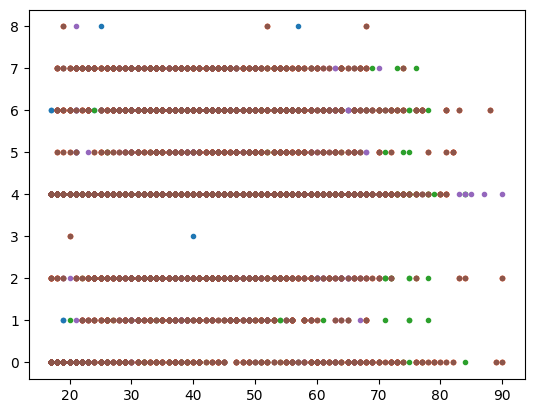

In [5]:
from DGE_experiments import predictive_experiment
import pandas as pd
genrun_all = {}
#dataset = 'seer'
dataset = 'adult'

max_n = 5000
nsyn = 5000
model_type = 'deepish_mlp'
num_runs = 5 #10

for layers, model_name in zip(range(1,4),['ctgan_shallow', 'ctgan', 'ctgan_deep']):

    workspace_folder, results_folder = get_folder_names(
            dataset, model_name, max_n=max_n, nsyn=nsyn)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        n_models=n_models*num_runs,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose,
                                        max_n=max_n,
                                        nsyn=nsyn)

    print(f'Model {model_name}\n')

    means, stds, all = predictive_experiment(X_gt,
                                            X_syns,
                                            workspace_folder=workspace_folder,
                                            results_folder=results_folder,
                                            task_type=model_type,
                                            save=save,
                                            load=load,
                                            plot=False,
                                            )

    print(means.to_latex())
    
    all['Hidden layers'] = layers
    genrun_all[layers] = all



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode


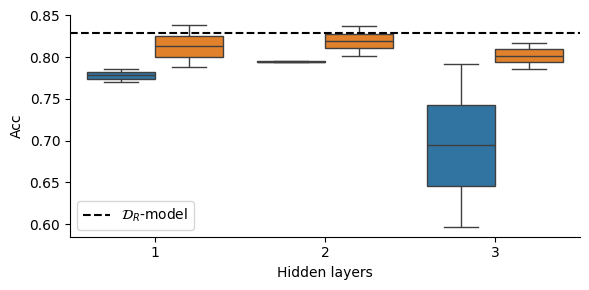

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

dfs = pd.concat(genrun_all)
oracle = dfs[dfs['Approach']=='Oracle']
dfs = dfs[(dfs['Approach']=="DGE$_{20}$")|(dfs['Approach']=='Naive (E)')]

metric = 'Acc'

sns.catplot(x='Hidden layers', y=metric, data=dfs, kind='box', hue='Approach', aspect = 2, height=3, showfliers = False, legend=False)
plt.tight_layout()
#draw line for oracle mean
plt.axhline(oracle[metric].mean(), color='black', linestyle='--', label='$\mathcal{D}_R$-model')
plt.legend()
os.makedirs('results/stories', exist_ok=True)
plt.savefig(f'results/stories/training_models_{dataset}_max_n{max_n}_nsyn_{nsyn}_{model_type}_{metric}.png', dpi=300)
plt.show()

## Model Evaluation

We compare the single baseline model vs the generative uncertainty model vs an oracle. Workflow.
0. Train and generate synthetic datasets $S_i$.
1. Take each synthetic dataset $S_i$ and split it up in train and test.
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic dataset's test set $S_{i,test}$, giving $\hat{M}^S_i$ [Naive evaluation]
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $M_i$ [Oracle evaluation]
5. Evaluate on the other synthetic datasets $\cup_{j\neq i} S_{j}$, giving $\hat{M}^G_i$ [DGE evaluation]
6. Average over all models $f_i$. 

N.B. the idea of the above, is that the trained model $f_i$ is the same for each evaluation type. In the model selection section, we will compare the performance of different model classes, where we will train a new model for each evaluation type (hence the aim is to evaluate which class is best, while the model itself may vary).

[2023-11-24T12:29:24.434700+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T12:29:24.436542+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T12:29:24.438033+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T12:29:24.439888+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Dataset: moons
Loading real data...
np.unique(y):  [0 1]
n_total 10000 n_train: 5000
Generating synthetic data with model:  ctgan_deep
Generating new data, filename is synthetic_data/moons/ctgan_deep/Xsyn_n5000_seed0.pkl
Training model 1/5


 17%|████████████████████████████▉                                                                                                                                         | 349/2000 [06:39<31:31,  1.15s/it]
[2023-11-24T12:36:09.952296+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T12:36:09.955677+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T12:36:09.958797+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T12:36:09.962435+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/moons/ctgan_deep/Xsyn_n5000_seed1.pkl
Training model 2/5


 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1049/2000 [19:53<18:02,  1.14s/it]
[2023-11-24T12:56:08.982930+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T12:56:08.985894+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T12:56:08.988753+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T12:56:08.992772+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/moons/ctgan_deep/Xsyn_n5000_seed2.pkl
Training model 3/5


 22%|█████████████████████████████████████▎                                                                                                                                | 449/2000 [08:08<28:07,  1.09s/it]
[2023-11-24T13:04:22.743018+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T13:04:22.746473+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T13:04:22.747421+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T13:04:22.749751+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/moons/ctgan_deep/Xsyn_n5000_seed3.pkl
Training model 4/5


 27%|█████████████████████████████████████████████▌                                                                                                                        | 549/2000 [09:52<26:06,  1.08s/it]
[2023-11-24T13:14:20.418704+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T13:14:20.421720+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T13:14:20.424443+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T13:14:20.427938+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/moons/ctgan_deep/Xsyn_n5000_seed4.pkl
Training model 5/5


 40%|██████████████████████████████████████████████████████████████████▎                                                                                                   | 799/2000 [14:31<21:50,  1.09s/it]


Finished with synthetic data generation!
Approach:  Oracle
Train model 1/5 and save as workspace/moons/ctgan_deep/nmax_5000_nsyn_5000/Naive/model_eval_deepish_mlp_0.pkl
Train model 2/5 and save as workspace/moons/ctgan_deep/nmax_5000_nsyn_5000/Naive/model_eval_deepish_mlp_1.pkl
Train model 3/5 and save as workspace/moons/ctgan_deep/nmax_5000_nsyn_5000/Naive/model_eval_deepish_mlp_2.pkl
Train model 4/5 and save as workspace/moons/ctgan_deep/nmax_5000_nsyn_5000/Naive/model_eval_deepish_mlp_3.pkl
Train model 5/5 and save as workspace/moons/ctgan_deep/nmax_5000_nsyn_5000/Naive/model_eval_deepish_mlp_4.pkl
Approach:  Naive
Approach:  DGE$_5$
Approach:  DGE$_{10}$
Approach:  DGE$_{20}$


[2023-11-24T13:30:01.896791+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T13:30:01.899083+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T13:30:01.900514+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T13:30:01.902337+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Dataset: circles
Loading real data...
np.unique(y):  [0 1]
n_total 10000 n_train: 5000
Generating synthetic data with model:  ctgan_deep
Generating new data, filename is synthetic_data/circles/ctgan_deep/Xsyn_n5000_seed0.pkl
Training model 1/5


 25%|█████████████████████████████████████████▍                                                                                                                            | 499/2000 [09:26<28:24,  1.14s/it]
[2023-11-24T13:39:35.830749+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T13:39:35.832428+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T13:39:35.834093+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T13:39:35.836012+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/circles/ctgan_deep/Xsyn_n5000_seed1.pkl
Training model 2/5


 27%|█████████████████████████████████████████████▌                                                                                                                        | 549/2000 [10:10<26:53,  1.11s/it]
[2023-11-24T13:49:50.789435+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T13:49:50.791077+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T13:49:50.792625+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T13:49:50.794492+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/circles/ctgan_deep/Xsyn_n5000_seed2.pkl
Training model 3/5


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                               | 849/2000 [15:42<21:17,  1.11s/it]
[2023-11-24T14:05:38.937102+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T14:05:38.938993+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T14:05:38.940926+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T14:05:38.942473+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/circles/ctgan_deep/Xsyn_n5000_seed3.pkl
Training model 4/5


 22%|█████████████████████████████████████▎                                                                                                                                | 449/2000 [07:59<27:35,  1.07s/it]
[2023-11-24T14:13:43.616437+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T14:13:43.617803+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T14:13:43.619301+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T14:13:43.621150+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/circles/ctgan_deep/Xsyn_n5000_seed4.pkl
Training model 5/5


 25%|█████████████████████████████████████████▍                                                                                                                            | 499/2000 [08:46<26:24,  1.06s/it]


Finished with synthetic data generation!
Approach:  Oracle
Train model 1/5 and save as workspace/circles/ctgan_deep/nmax_5000_nsyn_5000/Naive/model_eval_deepish_mlp_0.pkl
Train model 2/5 and save as workspace/circles/ctgan_deep/nmax_5000_nsyn_5000/Naive/model_eval_deepish_mlp_1.pkl
Train model 3/5 and save as workspace/circles/ctgan_deep/nmax_5000_nsyn_5000/Naive/model_eval_deepish_mlp_2.pkl
Train model 4/5 and save as workspace/circles/ctgan_deep/nmax_5000_nsyn_5000/Naive/model_eval_deepish_mlp_3.pkl
Train model 5/5 and save as workspace/circles/ctgan_deep/nmax_5000_nsyn_5000/Naive/model_eval_deepish_mlp_4.pkl
Approach:  Naive
Approach:  DGE$_5$
Approach:  DGE$_{10}$
Approach:  DGE$_{20}$
Dataset: adult
Loading real data...
   age          workclass  fnlwgt   education  education.num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53   

[2023-11-24T14:26:37.631224+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T14:26:37.633204+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T14:26:37.634881+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T14:26:37.636653+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


np.unique(y):  [1 2]
n_total 20000 n_train: 5000
Generating synthetic data with model:  ctgan_deep
Generating new data, filename is synthetic_data/covid/ctgan_deep/Xsyn_n5000_seed0.pkl
Training model 1/5


 15%|████████████████████████▌                                                                                                                                           | 299/2000 [11:15<1:04:04,  2.26s/it]
[2023-11-24T14:37:57.923180+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T14:37:57.927140+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T14:37:57.930519+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T14:37:57.934124+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/covid/ctgan_deep/Xsyn_n5000_seed1.pkl
Training model 2/5


 15%|████████████████████████▌                                                                                                                                           | 299/2000 [11:07<1:03:16,  2.23s/it]
[2023-11-24T14:49:12.201680+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T14:49:12.205705+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T14:49:12.208793+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T14:49:12.212274+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/covid/ctgan_deep/Xsyn_n5000_seed2.pkl
Training model 3/5


 25%|█████████████████████████████████████████▍                                                                                                                            | 499/2000 [18:22<55:16,  2.21s/it]
[2023-11-24T15:07:38.982689+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T15:07:38.983940+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T15:07:38.985886+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T15:07:38.993176+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/covid/ctgan_deep/Xsyn_n5000_seed3.pkl
Training model 4/5


 15%|████████████████████████▌                                                                                                                                           | 299/2000 [10:40<1:00:42,  2.14s/it]
[2023-11-24T15:18:24.892406+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T15:18:24.895860+0000][1530][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-11-24T15:18:24.898977+0000][1530][CRITICAL] module plugin_great load failed
[2023-11-24T15:18:24.902623+0000][1530][CRITICAL] module disabled: /opt/conda/envs/syn/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generating new data, filename is synthetic_data/covid/ctgan_deep/Xsyn_n5000_seed4.pkl
Training model 5/5


 15%|████████████████████████▌                                                                                                                                           | 299/2000 [10:32<1:00:00,  2.12s/it]


Finished with synthetic data generation!
Approach:  Oracle
Train model 1/5 and save as workspace/covid/ctgan_deep/nmax_5000_nsyn_5000/Naive/model_eval_deepish_mlp_0.pkl
Train model 2/5 and save as workspace/covid/ctgan_deep/nmax_5000_nsyn_5000/Naive/model_eval_deepish_mlp_1.pkl
Train model 3/5 and save as workspace/covid/ctgan_deep/nmax_5000_nsyn_5000/Naive/model_eval_deepish_mlp_2.pkl
Train model 4/5 and save as workspace/covid/ctgan_deep/nmax_5000_nsyn_5000/Naive/model_eval_deepish_mlp_3.pkl
Train model 5/5 and save as workspace/covid/ctgan_deep/nmax_5000_nsyn_5000/Naive/model_eval_deepish_mlp_4.pkl
Approach:  Naive
Approach:  DGE$_5$
Approach:  DGE$_{10}$
Approach:  DGE$_{20}$


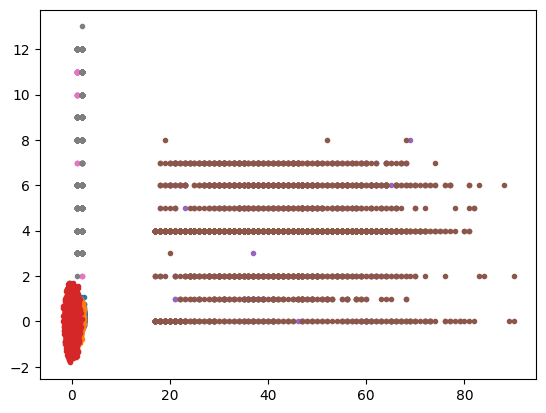

In [7]:
from DGE_experiments import model_evaluation_experiment

evaluation_means = {}
evaluation_std = {}
relative = False
max_n = 5000
nsyn = 5000
model_name = 'ctgan_deep'
#datasets = ['moons', 'circles', 'adult', 'seer', 'covid']
datasets = ['moons', 'circles', 'adult', 'covid']
model_type = 'deepish_mlp'
verbose = True

for dataset in datasets:
    print('Dataset:', dataset)
    workspace_folder, results_folder = get_folder_names(
        dataset, model_name, max_n=max_n, nsyn=nsyn)


    

    # load data
    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                          n_models=n_models,
                                          model_name=model_name,
                                          load_syn=load_syn,
                                          verbose=verbose,
                                          max_n=max_n,
                                          nsyn=nsyn)

    # get mean and std of dataset over different runs
    means, std, _ = model_evaluation_experiment(X_gt, X_syns, workspace_folder=workspace_folder, relative=relative,
                                             model_type=model_type,
                                             load=load,
                                             save=load,
                                             verbose=verbose,
                                             )

    evaluation_means[dataset] = means
    evaluation_std[dataset] = std


In [8]:
# mean across datasets
# per dataset
metric = 'Acc'
res = metric_different_datasets(evaluation_means, metric=metric, to_print=False)
std_df = metric_different_datasets(evaluation_std, metric=metric, to_print=False)

del std_df['Mean']
res = add_std(res, std_df)
if relative != 'l2':
    print(res.to_latex(float_format=lambda x: '%.3f' % x))
else:
    print(res.to_latex(float_format=lambda x: '%.5f' % x))

\begin{tabular}{llllll}
\toprule
{} &          Moons &        Circles &   Adult Income &       COVID-19 &   Mean \\
\midrule
Oracle     &  0.801 ± 0.131 &  0.644 ± 0.082 &  0.739 ± 0.083 &  0.907 ± 0.012 &  0.773 \\
Naive      &  0.888 ± 0.088 &   0.75 ± 0.188 &   0.742 ± 0.04 &  0.871 ± 0.083 &  0.813 \\
DGE\$\_5\$    &   0.75 ± 0.214 &  0.566 ± 0.119 &  0.694 ± 0.054 &  0.858 ± 0.012 &  0.717 \\
DGE\$\_\{10\}\$ &   0.75 ± 0.214 &  0.566 ± 0.119 &  0.694 ± 0.054 &  0.858 ± 0.012 &  0.717 \\
DGE\$\_\{20\}\$ &   0.75 ± 0.214 &  0.566 ± 0.119 &  0.694 ± 0.054 &  0.858 ± 0.012 &  0.717 \\
\bottomrule
\end{tabular}



### Vary the depth of the generative model


In [ ]:
from DGE_experiments import model_evaluation_experiment

genrun_means = {}
genrun_stds = {}
genrun_all = {}
#dataset = 'seer'
dataset = 'adult'
relative = False
verbose = False

max_n = 5000
nsyn = 5000
n_models = 20

for layers, model_name in zip(range(1,4),['ctgan_shallow', 'ctgan', 'ctgan_deep']):

    workspace_folder, results_folder = get_folder_names(
            dataset, model_name, max_n=max_n, nsyn=nsyn)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        p_train=p_train,
                                        n_models=n_models,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose,
                                        max_n=max_n,
                                        nsyn=nsyn)


    _, _, all = model_evaluation_experiment(X_gt, X_syns, workspace_folder=workspace_folder, relative=relative,
                                             model_type='deep_mlp',
                                             load=load,
                                             save=load,
                                             verbose=verbose,
                                             )

    all['Hidden layers'] = layers
    genrun_all[layers] = all
    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

metric = 'AUC'
dfs = pd.concat(genrun_all,axis=0)
dfs.reset_index(inplace=True)
dfs['Hidden layers'] = dfs['level_0']
dfs = dfs[(dfs['Approach']=="DGE$_{20}$")|(dfs['Approach']=="DGE (K=20)")|(dfs['Approach']=='Naive')|(dfs['Approach']=='Oracle')]
sns.catplot(x='Hidden layers', y=metric, data=dfs, kind='box', hue='Approach', aspect=2, height = 3, showfliers=False, legend=False)
plt.legend()
plt.tight_layout()
plt.savefig(f'results/stories/eval_models_{dataset}_{metric}.png', dpi=300)
#draw line for oracle mean


## Model Selection
Essentially repeat the above for different models

In [ ]:
from DGE_experiments import model_selection_experiment

# load data
#dataset = 'seer'
dataset = 'adult'
max_n = 5000
nsyn = 5000
X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        n_models=n_models,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose,
                                        max_n=max_n,
                                        nsyn=nsyn)



workspace_folder, results_folder = get_folder_names(
    dataset, model_name, max_n=max_n, nsyn=nsyn)

means_sorted, std = model_selection_experiment(X_gt, X_syns, relative=False,
                                                    workspace_folder=workspace_folder, 
                                                    load=load, save=save)




In [ ]:
A = add_std(means_sorted[metric].iloc[:5], std[metric])
B = means_sorted[metric].iloc[5:]
B.index = [f'{i}'.replace(' rank','') for i in B.index]
B = B.astype(int)
B.columns = ['' for i in B.columns]
C = pd.concat([A, B], axis=1)
print(C.to_latex())


### Run for different synthetic dataset size (Appendix)

In [ ]:
from DGE_experiments import model_selection_experiment
from DGE_data import get_real_and_synthetic
from DGE_utils import get_folder_names
import numpy as np
import sklearn

# load data
#dataset = 'seer'
dataset = 'adult'
max_n = 5000
p_train = 0.8
n_models = 20
model_name = 'ctgan_deep'
load=True
save = True
load_syn = True
verbose = False
means = {}
stds = {}
model_types = ['mlp', 'deepish_mlp', 'deep_mlp', 'largest_mlp']

for nsyn in [1000, 2000, 5000,10000,20000]:
    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                            p_train=p_train,
                                            n_models=n_models,
                                            model_name=model_name,
                                            load_syn=load_syn,
                                            verbose=verbose,
                                            max_n=max_n,
                                            nsyn=nsyn)



    workspace_folder, results_folder = get_folder_names(
        dataset, model_name, max_n=max_n, nsyn=nsyn)

    means_sorted, std = model_selection_experiment(X_gt, X_syns, relative=False,
                                                        workspace_folder=workspace_folder, 
                                                        load=load, save=save, model_types=model_types )

    means[nsyn] = means_sorted
    stds[nsyn] = std


In [ ]:
x = means.keys()
metric = 'AUC'
from importlib import reload
import matplotlib.pyplot as plt
plt=reload(plt)
for i in range(len(means_sorted[metric])):    
    y = [means[j][metric].iloc[i] for j in x]
    labels = means[5000][metric].columns
    plt.semilogx(x, y, label=labels)
    plt.xlabel('Synthetic dataset size')
    name = means[5000][metric].index[i]
    if 'rank' in name:
        plt.ylabel('Ranking')
    else:
        plt.ylabel(metric)
    plt.legend()
    plt.savefig(f'results/stories/model_selection_mlps_nsyn_{name}_{metric}.png')
    plt.show()

## Underrepresented group

### Model training

In [ ]:
from DGE_data import get_real_and_synthetic
dataset = 'covid'
n_models = 20
num_runs = 10
max_n = 2000
nsyn = 2000
model_name = 'ctgan'
load = True
save = True
load_syn = True
verbose = False
reduce_to = None # used to get a very large set of real samples for evaluation (to accurately performance on small subgroups)


In [ ]:
X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        n_models=n_models*num_runs,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose,
                                        max_n=max_n,
                                        nsyn=nsyn,
                                        reduce_to=reduce_to)

# Get some indication of the distribution of the data
X_gt.train().data.hist()

Let us define the minority category for each feature

In [ ]:
import pandas as pd
from synthcity.plugins.core.dataloader import GenericDataLoader

def find_minority(data, feature):
    # Get the value that is the minority

    # turn data into dataframe if GenericDataLoader
    if type(data) != pd.DataFrame:
        data = data.data
    # find minority value
    if data[feature].unique().shape[0] < 20:

        counts = data[feature].value_counts()
        percentages = counts/counts.sum()
        counts = counts[percentages>0.005]
        value = counts.index[-1]
        percentage = percentages[value]
        # Create function that selects the minority value
        def subset(X):
            Xout = X[X[feature]==value]
            if type(Xout) == pd.DataFrame:
                Xout = GenericDataLoader(Xout, target='target')
                if hasattr(X, 'targettype'):
                    Xout.targettype = X.targettype
            return Xout
    else:
        quantile = 0.1
        threshold = data[feature].quantile(1-quantile)
        value = f'>={threshold:.2f}'
        percentage = quantile
        # Create function that selects the minority value
        def subset(X):
            Xout = X[X[feature]>=threshold]
            if type(Xout) == pd.DataFrame:
                Xout = GenericDataLoader(Xout, target='target')
                if hasattr(X, 'targettype'):
                    Xout.targettype = X.targettype
            return Xout

    return subset, value, percentage


In [ ]:
from DGE_experiments import predictive_experiment
from DGE_utils import get_folder_names
from synthcity.plugins.core.dataloader import GenericDataLoader

values = {}
results = {}
percentages = {}

workspace_folder, results_folder = get_folder_names(
        dataset, model_name, max_n=max_n, nsyn=nsyn)

feature = 'ALL'
features = X_gt.unpack(as_numpy=False)[0].columns

_, _, res = predictive_experiment(X_gt,
                                    X_syns,
                                    workspace_folder=workspace_folder,
                                    results_folder=results_folder,
                                    save=save,
                                    load=load,
                                    plot=False,
                                    outlier=False
                                    )

results[feature] = res


for feature in features:
    subset, value, percentage = find_minority(X_gt.train(), feature)
    print(f'Feature {feature},\n minority value {value},\n minority percentage {percentage}')
    if percentage > 0.2:
        print('skipping due to not being minority')
        continue
    
    
    try:
        _, _, res = predictive_experiment(X_gt,
                                            X_syns,
                                            workspace_folder=workspace_folder,
                                            results_folder=results_folder,
                                            save=save,
                                            load=load,
                                            plot=False,
                                            outlier=subset
                                            )
    except ValueError:
        print('Skipping due to too heavy imbalance making AUC non-computable')
        continue

    percentages[feature] = percentage
    values[feature] = value
    results[feature] = res



add the category name to each subset (just for plotting)

In [ ]:
results_copy = results.copy() # to got back if necessary

sorted_percentages = sorted(percentages.items(), key=lambda item: item[1])
sorted_percentages = dict(sorted_percentages)
#results_ = {f'{key}:{value} ({round(100*sorted_percentages[key],1)}%)': results[key] for key in list(sorted_percentages.keys())[::-1]}
results_ = {f'{key}:{values[key]}': results[key] for key in list(sorted_percentages.keys())[::-1]}
results_ = dict({'Overall':results['ALL']}, **results_)
results = results_

Plot

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

normalize = True
if normalize:
    results_ = {}
    for key, res in results.items():
        results_key = []
        for group in res.groupby('Approach'):
            res_ = group[1].drop(columns='Approach')-res[res['Approach']=='Oracle'].drop(columns='Approach')
            res_['Approach'] = group[0]
            results_key.append(res_)
        results_key = pd.concat(results_key, axis=0)
        results_[key] = results_key
else:
    results_ = results.copy()

metric = 'AUC'
baseline = 'E'

df = pd.concat(results_)
df['Subset'] = df.index.get_level_values(0)

if normalize:
    df = df[(df['Approach']=='DGE$_{20}$')|(df['Approach']==f'Naive ({baseline})')] #|(df['Approach']=='DGE$_{20}$ (concat)')
else:
    df = df[(df['Approach']=='DGE$_{20}$')|(df['Approach']==f'Naive ({baseline})')|(df['Approach']=='Oracle')] #|(df['Approach']=='DGE$_{20}$ (concat)')
# draw a horizontal line at y=0
g = sns.catplot(data=df, hue='Approach', y=metric, x='Subset', kind='box', aspect=3, showfliers=False, legend=False)
g.set_xticklabels(rotation=20)
if normalize:
    plt.axhline(y=0, color='k', linestyle='--')
    g.set_ylabels(metric+r' on subset relative to $\mathcal{D}_R$-model')
plt.tight_layout()
plt.legend()
plt.savefig(f'results/stories/underrepresented_training_nsyn{nsyn}_nmax{max_n}_{metric}_{baseline}.png', dpi=300)


## Influence of synthetic data size (uncertainty plots and confidence curves)

Let's study the effect of synthetic data size. Resulting plots are saved in /results/

In [ ]:
from DGE_experiments import predictive_experiment
import pandas as pd


all_means = {}
all_stds = {}
model_name = 'ctgan'
n_models = 20
max_n = 2000
model_type = 'mlp'
#['adult', 'seer', 'covid', 'gaussian', 'circles', 'moons']
for dataset in ['adult', 'covid', 'gaussian', 'circles', 'moons']:
    for nsyn in [2000, 5000, 10000, 20000]:
        workspace_folder, results_folder = get_folder_names(
            dataset, model_name, max_n=max_n, nsyn=nsyn)

        X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                            p_train=p_train,
                                            n_models=n_models,
                                            model_name=model_name,
                                            load_syn=load_syn,
                                            verbose=verbose,
                                            max_n=max_n,
                                            nsyn=nsyn)


        print(f'Dataset {dataset}\n')

        means, stds, _ = predictive_experiment(X_gt,
                                                X_syns,
                                                workspace_folder=workspace_folder,
                                                results_folder=results_folder,
                                                task_type = model_type,
                                                save=save,
                                                load=load,
                                                plot=True,
                                                )



# Cross validation

In [ ]:
from sklearn.datasets import load_diabetes
import pickle
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import os
import torch


from synthcity.metrics.eval_performance import (
    PerformanceEvaluatorMLP,
    PerformanceEvaluatorXGB,
)
from synthcity.utils import reproducibility
from synthcity.plugins import Plugins
import synthcity.logger as log
from synthcity.plugins.core.dataloader import GenericDataLoader
from DGE_utils import metric_different_datasets, mean_across_pandas, add_std, get_folder_names

reproducibility.clear_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


assert device.type == 'cuda'


In [ ]:
from DGE_data import get_real_and_synthetic
from DGE_utils import get_folder_names, tt_predict_performance, cat_dl
from DGE_data import get_real_and_synthetic
from DGE_experiments import cross_val
import pandas as pd
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

# let's restrict ourselves to classification datasets
#datasets = ['moons', 'circles', 'breast_cancer',
#            'adult',  'seer', 'covid']
datasets = ['moons', 'circles', 'breast_cancer',
            'adult', 'covid']
# ['moons', 'circles','cal_housing', 'adult', 'diabetes', 'breast_cancer',  'seer', 'cutract' ]
model_name = 'ctgan'  # synthetic data model

p_train = 0.8  # proportion of training data for generative model. Default values if None
n_models = 20  # number of models in ensemble, for each run
max_n = 2000  # maximum number of data points to use for training generative model.
nsyn = 2000  # number of synthetic data points per synthetic dataset. Defaults to same as generative training size if None

num_runs = 5  # Number of runs. Don't choose to large, since total number of synthetic datasets is num_runs*n_models

load = True  # results
load_syn = True  # data
save = True  # save results and data

verbose = False




In [ ]:
num_runs = 5
model_type = 'deepish_mlp'
model_name = 'ctgan'
nsyn = 5000
max_n = 2000
p_train = 0.8
n_models = 20
cross_fold = 5
load_syn = True
load = True
save = True
verbose = True

scores_s_all = {}
scores_r_all = {}

#datasets = ['moons', 'circles', 'adult', 'seer', 'covid']
datasets = ['moons', 'circles', 'adult', 'covid']

for dataset in ['adult']:
    workspace_folder, results_folder = get_folder_names(
        dataset, model_name, max_n=max_n, nsyn=nsyn)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                          p_train=p_train,
                                          n_models=n_models*num_runs,
                                          model_name=model_name,
                                          load_syn=load_syn,
                                          verbose=verbose,
                                          max_n=max_n,
                                          nsyn=nsyn)

    print(f'Dataset {dataset}\n')

    scores_s, scores_r = cross_val(X_gt,
                                  X_syns,
                                  workspace_folder=workspace_folder,
                                  results_folder=results_folder,
                                  save=save,
                                  load=load,
                                  task_type=model_type,
                                  cross_fold=cross_fold,
                                  verbose=verbose
                                  )

    scores_s_all[dataset] = scores_s
    scores_r_all[dataset] = scores_r


In [ ]:
metric = 'AUC'

for dataset in datasets[-3:]:
    print(dataset)
    scores_r_all[dataset]['Test set'] = 'Real'
    scores_s_all[dataset]['Test set'] = 'Synthetic'
    scores_ = pd.concat([scores_r_all[dataset], scores_s_all[dataset]],axis=0)
    scores_.reset_index(inplace=True)
    scores_.rename(columns={'index':'Approach'}, inplace=True)
    scores_ = scores_.mask(scores_ == 'DGE$_{20]$','DGE$_{20}$')
    scores_ = scores_.mask(scores_ == 'DGE$_{20}$ (concat)','Naive (C)')
    
    sns.catplot(data=scores_, x='approach', y=metric, hue='Test set', kind='box', showfliers=False)
    os.makedirs(f'./results/cross_val/', exist_ok=True)
    plt.savefig(f'./results/cross_val/{dataset}_{metric}_{model_name}_nsyn_{nsyn}_maxn{max_n}_{model_type}.png')
    plt.show()
